In [1]:
#importing various packages
import time
import os
os.environ["PATH"] += os.pathsep + "C:/Users/Ankita/Downloads/windows_10_msbuild_Release_graphviz-10.0.1-win32/Graphviz/bin"
start = time.time()
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report
import tracemalloc
tracemalloc.start()
 
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


Reading Data

In [2]:
path_to_file="C:/Users/Ankita/Desktop/ML/bank-data/bank-data.csv"
bank_data=pd.read_csv(path_to_file, sep=";")
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Modifying the Dataset:

Duration of a call is not known beforehand and once we know the duration, we also know if the final answer is yes or no. Hence we drop the duration column.
We drop the default column because it has too many 'unknown' values. We drop the 'pdays' column because it has high standard deviation and as less than 5% of the people have been contacted before.

In [4]:
bank_data=bank_data.drop(columns=['duration'])
bank_data=bank_data.drop(columns=['default'])
bank_data=bank_data.drop(columns=['pdays'])

#Changing some of the categorical attributes to numerical attributes using Label Encoding.
categorical_cols = ['job', 'marital','month', 'contact', 'day_of_week']

#Changing the ordinal variables manually preserving the order
bank_data = pd.get_dummies(bank_data, columns = categorical_cols, drop_first = True)
bank_data['housing'] = bank_data['housing'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data['loan'] = bank_data['loan'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data['education'] = bank_data['education'].map({'unknown':-1, 'illiterate':0, 'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 'high.school':4,'professional.course':5,'university.degree':6})
bank_data['poutcome']=bank_data['poutcome'].map({'nonexistent':0, 'success':1, 'failure':-1})

X = bank_data.drop(['y'], axis = 1)
y = bank_data['y']

feature_names=X.columns
#Splitting the data into training and test samples (default 75-25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,age,education,housing,loan,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,...,month_mar,month_may,month_nov,month_oct,month_sep,contact_telephone,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
549,50,1,0,0,1,0,0,1.1,93.994,-36.4,...,0,1,0,0,0,1,0,0,1,0
1974,26,4,1,1,4,0,0,1.1,93.994,-36.4,...,0,1,0,0,0,1,0,0,0,0
20992,34,4,-1,1,3,0,0,1.4,93.444,-36.1,...,0,0,0,0,0,0,0,1,0,0
1730,30,3,-1,1,1,0,0,1.1,93.994,-36.4,...,0,1,0,0,0,1,0,0,0,0
26913,29,6,-1,1,2,0,0,-0.1,93.200,-42.0,...,0,0,1,0,0,0,0,1,0,0


# Decision Tree

In [5]:
DT = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Visualising the Tree

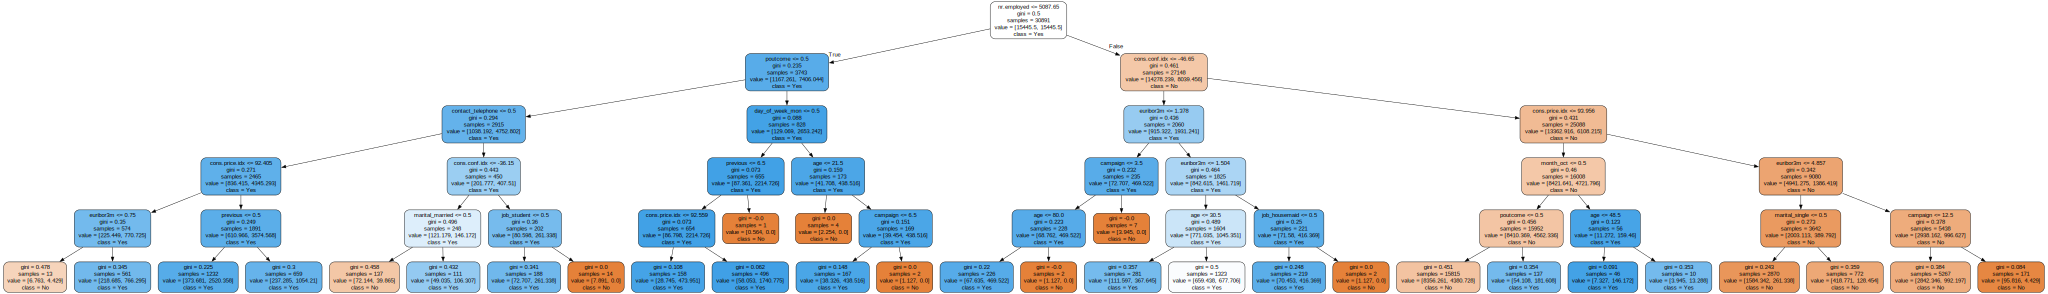

In [6]:
#visualizing the decision tree model
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from sklearn.tree import export_graphviz

export_graphviz(
        DT,
        out_file=str(IMAGES_PATH / "bank_tree.dot"),  
        feature_names=X.columns,
        class_names=['No','Yes'],
        rounded=True,
        filled=True
    )
from graphviz import Source
Source.from_file(IMAGES_PATH / "bank_tree.dot")    

Testing the Classifier 

In [7]:
y_pred = DT.predict(X_test)
y_test = np.array(y_test).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.94      0.87      0.90      9144
         yes       0.35      0.58      0.44      1153

    accuracy                           0.83     10297
   macro avg       0.65      0.73      0.67     10297
weighted avg       0.88      0.83      0.85     10297



In [8]:
print("Accuracy for Decision Tree: ", np.round(sklearn.metrics.accuracy_score(y_test, y_pred)*100,2), '%')
print("Precision for Decision Tree: ", np.round(sklearn.metrics.precision_score(y_test, y_pred,pos_label='yes')*100,2), '%')
print("Recall for Decision Tree: ", np.round(sklearn.metrics.recall_score(y_test, y_pred,pos_label='yes')*100,2), '%')
print("F1 score for Decision Tree:", np.round(sklearn.metrics.f1_score(y_test, y_pred,pos_label='yes')*100,2), "\n")

Accuracy for Decision Tree:  83.44 %
Precision for Decision Tree:  35.47 %
Recall for Decision Tree:  58.46 %
F1 score for Decision Tree: 44.15 



Confusion Matrix

<function matplotlib.pyplot.show(close=None, block=None)>

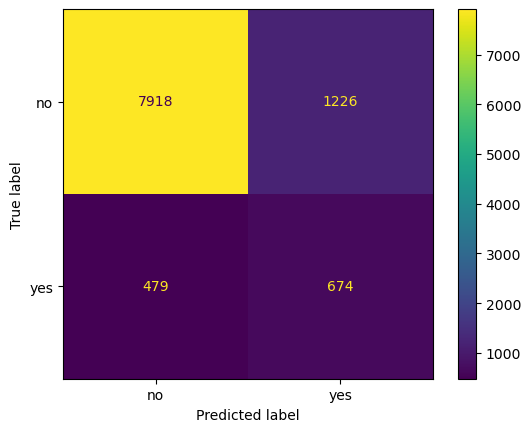

In [9]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=DT.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DT.classes_)
disp.plot()
plt.show

Time and Memory consumed

In [10]:
current, peak = tracemalloc.get_traced_memory()  # take a snapshot of current memory usage
print(f"Current memory usage is {current / 10**6}MB\nPeak memory usage was {peak / 10**6}MB")

tracemalloc.stop()  # stop tracking memory usage

time.time()-start

Current memory usage is 26.796316MB
Peak memory usage was 39.386725MB


47.240846395492554

# Naive Bayes Classifier

In [11]:
from sklearn.naive_bayes import GaussianNB
tracemalloc.start()
start = time.time()
NB = GaussianNB()
NB.fit(X_train, y_train)
GaussianNB()


GaussianNB()

Testing the Naive Bayes model

In [12]:
y_pred = NB.predict(X_test)
y_test = np.array(y_test).flatten()

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.93      0.91      0.92      9144
         yes       0.40      0.45      0.42      1153

    accuracy                           0.86     10297
   macro avg       0.66      0.68      0.67     10297
weighted avg       0.87      0.86      0.87     10297



In [13]:
print("Accuracy for Naive Bayes: ", np.round(sklearn.metrics.accuracy_score(y_test, y_pred)*100,2), '%')
print("Precision for Naive Bayes: ", np.round(sklearn.metrics.precision_score(y_test, y_pred,pos_label='yes')*100,2), '%')
print("Recall for Naive Bayes: ", np.round(sklearn.metrics.recall_score(y_test, y_pred,pos_label='yes')*100,2), '%')
print("F1 score for Naive Bayes:", np.round(sklearn.metrics.f1_score(y_test, y_pred,pos_label='yes')*100,2), "\n")

Accuracy for Naive Bayes:  86.2 %
Precision for Naive Bayes:  39.69 %
Recall for Naive Bayes:  44.75 %
F1 score for Naive Bayes: 42.07 



Confusion Matrix

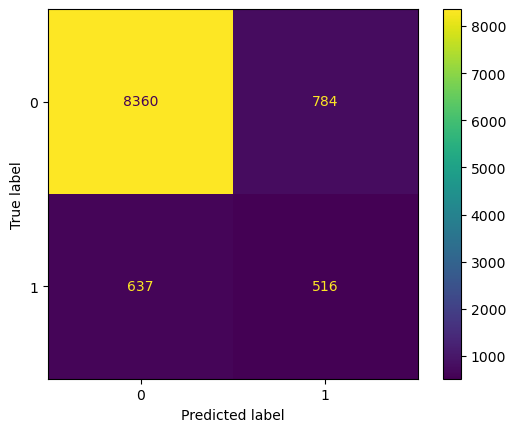

In [14]:
cm2 = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

Time and Memory consumed

In [15]:

current, peak = tracemalloc.get_traced_memory()  # take a snapshot of current memory usage
print(f"Current memory usage is {current / 10**6}MB\nPeak memory usage was {peak / 10**6}MB")

tracemalloc.stop()  # stop tracking memory usage

time.time()-start

Current memory usage is 1.592645MB
Peak memory usage was 27.499199MB


12.675482273101807

# Random Forest Classifier

In [16]:
start = time.time()
tracemalloc.start()
DT2 = RandomForestClassifier(max_depth=4, random_state=42, class_weight='balanced')
DT2.fit(X_train, y_train)
y_pred = DT2.predict(X_test)
end = time.time()
print("Time taken to fit the Random Forest Classifier model:", end-start, "seconds\n")

current, peak = tracemalloc.get_traced_memory()  # take a snapshot of current memory usage
print(f"Memory usage: {peak / 10**6} MB")
tracemalloc.stop()

Time taken to fit the Random Forest Classifier model: 3.5135228633880615 seconds

Memory usage: 14.834901 MB


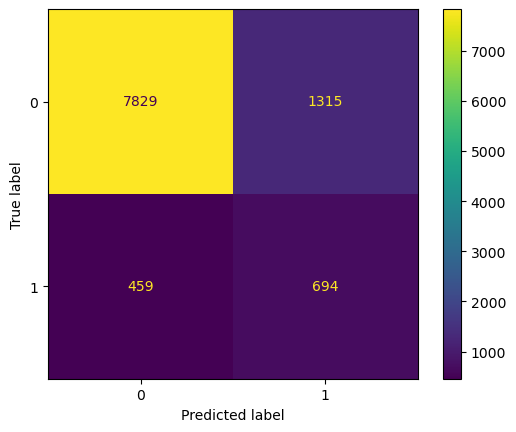

In [17]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
print("Accuracy for Random Forest: ", np.round(sklearn.metrics.accuracy_score(y_test, y_pred)*100,2), '%')
print("Precision for Random Forest: ", np.round(sklearn.metrics.precision_score(y_test, y_pred,pos_label='yes')*100,2), '%')
print("Recall for Random Forest: ", np.round(sklearn.metrics.recall_score(y_test, y_pred,pos_label='yes')*100,2), '%')
print("F1 score for Random Forest:", np.round(sklearn.metrics.f1_score(y_test, y_pred,pos_label='yes')*100,2), "\n")

Accuracy for Random Forest:  82.77 %
Precision for Random Forest:  34.54 %
Recall for Random Forest:  60.19 %
F1 score for Random Forest: 43.9 

